# API calculation check

We've discovered a discrepancy between our (NOAA ERD) calculation of API from desnity, and the one done by the ESTS lab.

This notebook is exploring that difference.

NOTE that NOAA's API calculation is distict code in two place:

Conversion from density to API is in the nucos code:

https://github.com/NOAA-ORR-ERD/PyNUCOS

(Note that specific gravity at 15C is computed separately from API as well, also in the NUCOS code -- note that the latest version of NUCOS (2.11) uses a slightly different value for the density of water at 60F -- but only in the fourth digit. It now uses the ASTM D1250)

The density interpolation / extrapolation is in the adios_db code, in:

`adios_db/computation/physical_properties.py`

(https://github.com/NOAA-ORR-ERD/adios_oil_database)

The only difference between the NOAA and the ECCC method is that NOAA uses a linear extrapolation for density as a function of temperature, and ECCC uses an exponential. In this case, we are extrapoling from 15C to 15.56C, which is a very small difference.


## The issue

This came up because we discovered that the calculation of API in the adios_db didn't match the value provided by Env CA. One example:

(from our validation code)

`EC02234` -- Access West Blend Winter:

    E043: API, 20.9 does not match density at 60F. API should be: 21.4

(note that our ID, EC02234 is based on your ID, which in this case is 2234)

The density, in this case, is:  0.925 g/cm³ at 15 °C

Which if I convert to API gives me: API 21.43


## The methods

ECCC uses these formulas:

Since we do not have the density value measured at 60 °F (15.56 °C), we calculate the API gravity at 60 °F by extrapolation from the density measurement at 0 and 15C using the following equations:

API Gravity = $\frac{141.5}{SG_{60}} - 131.5$

Where $SG_{60}$ is the specific gravity of the oil at at 60F (15.56C)

This is the standard definition of API gravity.

$SG_{60}$ is the ratio of the density of the oil to density of fresh water, both at 60F

$SG_{60} = \frac{\rho_{60-oil}}{\rho_{60-water}}$

However, there may not be a measurement of the density of oil at 60F. For instance, modern labs often use 15C as a standard, where 60F = 15.56C. To estimate the density at 15.56C, a slight extrapolation is required.

The ECCC equation, when provided the density of oil at 0C and 15C:

$SG_{60} = \frac{ \rho_{oil-0C} \, \cdot \,
                   \exp{\left(\ln\left(\rho_{oil-15C}\right) -
                              \ln\left(\rho_{oil-0C}\right)
                        \right) \cdot 15.65 }}
                {\rho_{water-15.56C}}$

where $\rho_{oil-0C}$ and $\rho_{oil-15C}$ are the measured oil densities at 0°C and 15°C, respectively, and $\rho_{water-15.56C}$ is the literature value for the density of water at 15.56 °C.

ASTM D1250 defines $\rho_{water-15.56C}$ as 999.016 $kg/m^3$

ECCC is using a value of 0.99902 $g/cm^3$ same, rounded to 5 figures


In [1]:
from math import exp, log
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
# some constants
# The official density of water at 60 °F according to the 2008 edition of ASTM D1250
# is 999.016 kg/m3 (found in Wikipedia)

# rho_h2O_60F = .999016
# rho_h2O_60F = 0.99898 # from: https://www.engineeringtoolbox.com/water-density-specific-weight-d_595.html
rho_h2O_60F = 0.99902 # the value ECCC is using.


In [3]:
def ecc_density_to_API(rho_0, rho_15):
    SG = ecc_specific_gravity(rho_0, rho_15)
    API = ecc_API_from_SG_60F(SG)
    return API

def ecc_API_from_SG_60F(SG):
    return  ((141.5 / SG) - 131.5)

def ecc_specific_gravity(rho_0, rho_15):
    return (rho_0 * (exp(log(rho_15) - log(rho_0) / 15 * 15.56))) / rho_h2O_60F
        

In [4]:
from adios_db.computation.physical_properties import Density
import unit_conversion as uc  # the py_nucos library


def noaa_density_to_API(rho_0, rho_15):
    # density in kg/m^3, temp in K
    density = Density([(rho_0 * 1000, 273.15),
                       (rho_15 * 1000, 288.15)])
    rho = density.at_temp(288.71556)  ## 60F in K
    API = uc.convert("kg/m^3", "API", rho)
    return API


In [5]:
# An example, from EC02234: Access West Blend Winter
  
rho_0 = 0.94  # g/cm³
rho_15 = 0.925  # g/cm³

API = ecc_density_to_API(rho_0, rho_15)
print(f"API from the ECCC equations: {API=:.2f}")

API = noaa_density_to_API(rho_0, rho_15)
print(f"API from the NOAA code: {API=:.2f}")


API from the ECCC equations: API=20.97
API from the NOAA code: API=21.42


The results are different, but not very different: In this example, 20.97 vs 21.43

The API value in this record is provided as 20.9 - very close to the 20.97 I get with the ECCC method.

So the difference is the extrapolation.

See: https://adios.orr.noaa.gov/oils/EC02234

However, I still don't get why it's as different as it is.

In [6]:
# breaking out the calculation into parts:

def ecc_density_to_API(rho_0, rho_15):
    SG = ecc_specific_gravity(rho_0, rho_15)
    API = ecc_API_from_SG_60F(SG)
    return API

def ecc_API_from_SG_60F(SG):
    return  ((141.5 / SG) - 131.5)

def ecc_specific_gravity(rho_0, rho_15):
    return (rho_0 * (exp(log(rho_15) - log(rho_0) / 15 * 15.56))) / rho_h2O_60F

def ecc_specific_gravity2(rho_0, rho_15):
    return ecc_density_at_t(rho_0, rho_15, 15.56) / rho_h2O_60F

def ecc_specific_gravity3(rho_0, rho_15):
    return ecc_density_at_t2(rho_0, rho_15, 15.56) / rho_h2O_60F

def ecc_density_at_t(rho_0, rho_15, t):
    return (rho_0 * (exp(log(rho_15) - log(rho_0) / 15 * t)))

def ecc_density_at_t2(rho_0, rho_15, t):
    return exp(log(rho_0) + ((log(rho_15) - log(rho_0)) * t / 15.56))

def ecc_density_to_API2(rho_0, rho_15):
    SG = ecc_specific_gravity3(rho_0, rho_15)
    API = ecc_API_from_SG_60F(SG)
    return API

assert ecc_specific_gravity(rho_0, rho_15) == ecc_specific_gravity2(rho_0, rho_15)
    

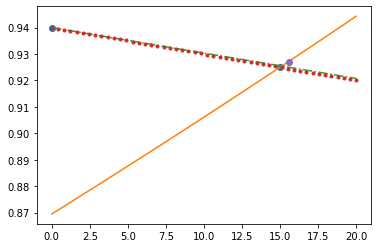

In [7]:
temps = np.linspace(0, 20)


ecc_rho = [ecc_density_at_t(rho_0, rho_15, t) for t in temps]
ecc_rho2 = [ecc_density_at_t2(rho_0, rho_15, t) for t in temps]

density = Density([(rho_0 * 1000, 273.15),
                   (rho_15 * 1000, 288.15)])
noaa_rho = [density.at_temp(t + 273.15) / 1000 for t in temps]

plt.plot((0.0, 15.0), (rho_0, rho_15), 'o',
          temps, ecc_rho, '-',
          temps, ecc_rho2, '-.',
          temps, noaa_rho, '.',
          15.56, ecc_density_at_t(rho_0, rho_15, 15.56), 'o',
        )

In [8]:
# An example, from EC02234: Access West Blend Winter
  
rho_0 = 0.94  # g/cm³
rho_15 = 0.925  # g/cm³

API = ecc_density_to_API(rho_0, rho_15)
print(f"API from the ECCC equations: {API=:.2f}")

API = ecc_density_to_API2(rho_0, rho_15)
print(f"API from the corrected ECCC equations: {API=:.2f}")

API = noaa_density_to_API(rho_0, rho_15)
print(f"API from the NOAA code: {API=:.2f}")

API from the ECCC equations: API=20.97
API from the corrected ECCC equations: API=21.32
API from the NOAA code: API=21.42
